# Домашнее задание №4: Архитектуры Transformer

**[0 баллов] Считайте изображение и получите две вариации изображения: HR, LR.**

In [1]:
# скачаем изображение
!wget -O hr.png https://github.com/aiedu-courses/super_resolution/blob/main/data/hr.png?raw=true

--2024-05-16 18:07:44--  https://github.com/aiedu-courses/super_resolution/blob/main/data/hr.png?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/aiedu-courses/super_resolution/raw/main/data/hr.png [following]
--2024-05-16 18:07:45--  https://github.com/aiedu-courses/super_resolution/raw/main/data/hr.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aiedu-courses/super_resolution/main/data/hr.png [following]
--2024-05-16 18:07:45--  https://raw.githubusercontent.com/aiedu-courses/super_resolution/main/data/hr.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HT

In [2]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import torch
import torch.nn.functional as F
import math

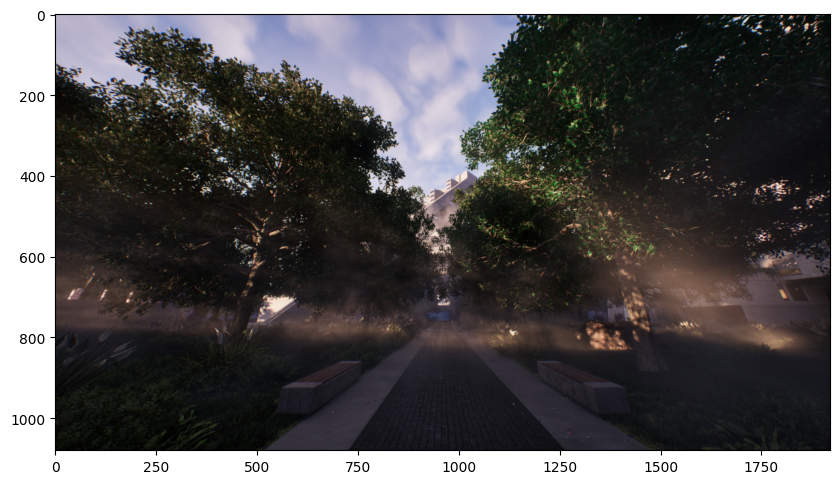

In [3]:
# считаем изображение при помощи библиотеки pillow и приведем к RGB формату
hr_img = Image.open("hr.png").convert("RGB")
_ = plt.figure(figsize=(10, 7))
_ = plt.imshow(hr_img)

In [4]:
# случайным образом получим HR изображение размера (256, 256)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomCrop((256, 256))
    ]
)

# получим LR изображение размера (64, 64) при помощи простого resize
resize_transform = transforms.Resize((64, 64))

# tensor to PIL
tensor2pil = transforms.ToPILImage()

In [5]:
hr_img = transform(hr_img)
lr_img = resize_transform(hr_img)

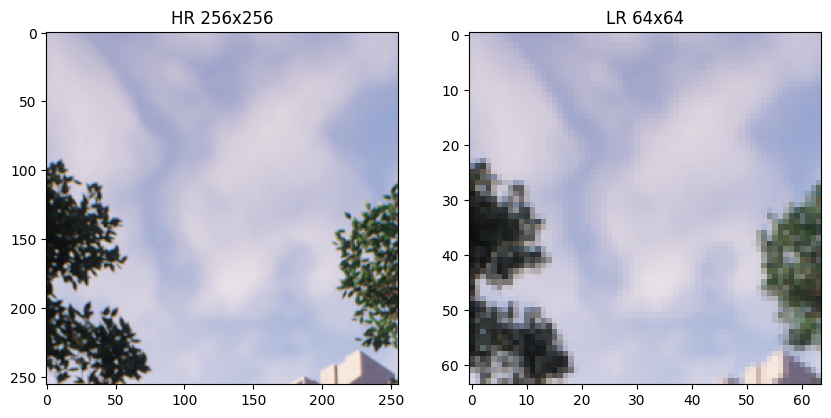

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(tensor2pil(hr_img))
ax[0].set_title("HR 256x256")

ax[1].imshow(tensor2pil(lr_img))
ax[1].set_title("LR 64x64")

plt.show()

In [7]:
hr_img = hr_img.unsqueeze(0)
lr_img = lr_img.unsqueeze(0)

### **[0 баллов] Подсчет параметров модели**

In [12]:
# возьмите реализацию функции из ДЗ №2: Архитектуры CNN
def calculate_total_parameters(model: nn.Module) -> int:
    """
        Parameters
        ----------
        model: nn.Module
            Объект PyTorch модели.

        Returns
        -------
        int
            Число всех параметров модели.
    """
    ...

### **[2 балла] ShallowFeatureExtractor**

In [10]:
# реализуйте объявленные методы класса
class ShallowFeatureExtractor(nn.Module):
    def __init__(self, inf: int = 3, outf: int = 32) -> None:
        """
            Conv -> ReLU

            Parameters
            ----------
            inf: int
                Количество каналов входного изображения.
            outf: int
                Количество каналов выходной feature map.

            Returns
            -------
            None
        """
        ...

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        ...

In [ ]:
sfe = ShallowFeatureExtractor()
assert sfe(lr_img).shape == (1, 32, 64, 64)
print(f"ShallowFeatureExtractor parameters = {calculate_total_parameters(sfe)}")

### **[3 балла] ChannelAttention**

In [ ]:
# реализуйте объявленные методы класса
class ChannelAttention(nn.Module):
    def __init__(self, nf: int = 32, r: int = 2) -> None:
        """
            Parameters
            ----------
            nf: int
                Количество каналов входной и выходной feature map.
            r: int
                Коэффициент сжатия и расширения по каналом для сверточного блока.

            Returns
            -------
            None
        """
        self.avg_pool = ...  # squeeze операция, при помощи пулинга сжимаем по осям H,W до тензора размера (bs, c, 1, 1)
        self.body = ...  # Conv -> ReLU -> Conv -> Sigmoid, первая свертка делает сжатие каналов, вторая расширение

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        s = ...  # примените squeeze блок
        f = ...  # примените сверточный блок к s
        out = ...  # при помощи f перевзвесьте значения x
        return out

In [ ]:
ca = ChannelAttention()
assert ca(sfe(lr_img)).shape == (1, 32, 64, 64)
print(f"ChannelAttention parameters = {calculate_total_parameters(ca)}")

### **[3 балла] HFM**

In [14]:
# реализуйте объявленные методы класса
class HFM(nn.Module):
    def __init__(self, k: int = 2) -> None:
        """
            Parameters
            ----------
            k: int
                Размер окна, значения которого будут усредняться.

            Returns
            -------
            None
        """
        self.avg_pool = ...  # слой AvgPool, размер ядра и шага равен k

    def forward(self, x: torch.FloatTensor) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        down = ...  # при помощи AvgPool получите тензор меньше в k раз по разрешению, который пойдет LR пути
        high = ...  # получите тензор high-frequency значений, вычитая из входного тензора интерполированный тензор, для интерполяции можно использовать F.interpolate
        return down, high

In [ ]:
hfm = HFM()
down_img, high_img = hfm(sfe(lr_img))
assert down_img.shape == (1, 32, 32, 32)
assert high_img.shape == (1, 32, 64, 64)
print(f"HFM parameters = {calculate_total_parameters(hfm)}")

### **[2 балла] AdaptiveScale**

In [16]:
# реализуйте объявленные методы класса
class AdaptiveScale(nn.Module):
    def __init__(self, init_value: float = 1e-3) -> None:
        """
            Parameters
            ----------
            init_value: float
                Начальное значение, которым инициализируется обучаемый параметр scale.

            Returns
            -------
            None
        """
        self.scale = ...  # используйте nn.Parameter для создания обучаемого параметра scale

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        scaled = ...  # отмасштабируйте значения входного тензора, используя обучаемый параметр scale
        return scaled

In [ ]:
adsc = AdaptiveScale()
assert torch.allclose(lr_img * 1e-3, adsc(lr_img))
print(f"AdaptiveScale parameters = {calculate_total_parameters(adsc)}")

### **[3 балла] ResidualUnit**

In [18]:
# реализуйте объявленные методы класса
class ResidualUnit(nn.Module):
    def __init__(self, nf: int = 32, r: int = 2) -> None:
        """
            Parameters
            ----------
            nf: int
                Количество каналов входной и выходной feature map.
            r: int
                Коэффициент сжатия и расширения по каналом для сверточного блока.

            Returns
            -------
            None
        """
        self.ru = ...  # Conv -> ReLU -> Conv, первая свертка делает сжатие каналов, вторая расширение
        self.lambda_res = ...  # задайте слой обучаемого параметра scale для ветки residual, используйте init_value = 1
        self.lambda_f = ...  # задайте слой обучаемого параметра scale для ветки feature map, используйте init_value = 1

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        ru = ...  # примените сверточный блок с сжатием и расширением количества каналов
        out = ...  # примените слои AdaptiveScale к residual, feature map и сложите для получения выхода
        return out

In [ ]:
ru = ResidualUnit()
assert ru(sfe(lr_img)).shape == (1, 32, 64, 64)
print(f"ResidualUnit parameters = {calculate_total_parameters(ru)}")

### **[4 балла] ARFB**

In [ ]:
# реализуйте объявленные методы класса
class ARFB(nn.Module):
    def __init__(self, nf: int = 32, r: int = 2) -> None:
        """
            Parameters
            ----------
            nf: int
                Количество каналов входной и выходной feature map.
            r: int
                Коэффициент сжатия и расширения по каналом для сверточного блока.

            Returns
            -------
            None
        """
        self.ru1 = ...  # первый ResidualUnit с параметрами nf, r
        self.ru2 = ...  # второй ResidualUnit с параметрами nf, r
        self.conv_re = ...  # свертка 1x1 для уменьшения числа каналов после конкатенации выходов RU с 2nf до nf
        self.conv3x3 = ...  # свертка 3x3 из nf в nf
        self.relu = ...  # активация ReLU между conv_re и conv3x3

        self.lambda_res = ...  # задайте слой обучаемого параметра scale для ветки residual, используйте init_value = 1
        self.lambda_f = ...  # задайте слой обучаемого параметра scale для ветки feature map, используйте init_value = 1

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        y_ru1 = ...  # примените первый RU
        y_ru2 = ...  # примените второй RU
        concat = ...  # сконкатенируйте выходы RU блоков по оси каналов
        red = ...  # примените свертку 1x1 с последующей активацией ReLU
        fs = ...  # примените свертку 3x3
        out = ...  # примените слои AdaptiveScale к residual, feature map и сложите для получения выхода
        return out

In [ ]:
arfb = ARFB()
assert arfb(sfe(lr_img)).shape == (1, 32, 64, 64)
print(f"ARFB parameters = {calculate_total_parameters(arfb)}")

### **[5 баллов] HPB**

In [ ]:
# реализуйте объявленные методы класса
class HPB(nn.Module):
    def __init__(self, nf: int = 32, arfb_n: int = 5, arfb_r: int = 2, hfm_k: int = 2, ca_r: int = 2) -> None:
        """
            Parameters
            ----------
            nf: int
                Количество каналов входной и выходной feature map.
            arfb_n: int
                Количество ARFB блоков, которые применяются в LR пути и шарят веса, фактически один блок, применяется arfb_n раз.
            arfb_r: int
                Коэффициент сжатия и расширения для блоков ARFB.
            hfm_k: int
                Размер окна, значения которого будут усредняться в HFM блоке.
            ca_r: int
                Коэффициент сжатия и расширения для блока ChannelAttention.

            Returns
            -------
            None
        """
        self.arfb_head = ...  # первый ARFB блок, который обрабатывает входной feature map
        self.hfm = ...  # HFM блок
        self.arfb_high = ...  # ARFB блок, который обрабатывает тензор high-frequency значений по HR пути
        self.arfb_down = ...  # ARFB блок, который последовательно обрабатывает тензор по LR пути arfb_n раз
        self.conv_re = ...  # свертка 1x1 для уменьшения числа каналов после конкатенации выходов LR и HR путей
        self.ca = ...  # блок ChannelAttention
        self.arfb_tail = ...  # последний блок ARFB
        self.arfb_n = arfb_n

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        head = ...  # примените первый ARFB блок
        down, high = ...  # примените HFM блок
        high = ...  # прогоните high тензор через ARFB блок для HR пути
        # arfb_n раз примените ARFB блок для LR пути к тензору down
        for _ in range(...):
            down = ...
        updown = ...  # примените интерполяцию тензора из LR пути к исходному разрешению при помощи F.interpolate
        concat = ...  # сконкатенируйте тензоры с LR и HR путей по оси каналов
        red = ... # примените свертку 1x1 для уменьшения числа каналов с 2nf до nf
        ca = ...  # примените блок ChannelAttention
        out = ...  # примените последний ARFB блок и сложите с identity, чтобы получить глобальное residual connection
        return out

In [ ]:
hpb = HPB()
assert hpb(sfe(lr_img)).shape == (1, 32, 64, 64)
print(f"HPB parameters = {calculate_total_parameters(hpb)}")

### **[3 балла] LCB**

In [20]:
# реализуйте объявленные методы класса
class LCB(nn.Module):
    def __init__(self, nb: int = 3, nf: int = 32, arfb_n: int = 5, arfb_r: int = 2, hfm_k: int = 2, ca_r: int = 2) -> None:
        """
            Parameters
            ----------
            nb: int
                Количество HPB блоков.
            nf: int
                Количество каналов входной и выходной feature map.
            arfb_n: int
                Количество ARFB блоков, которые применяются в LR пути и шарят веса, фактически один блок, применяется arfb_n раз.
            arfb_r: int
                Коэффициент сжатия и расширения для блоков ARFB.
            hfm_k: int
                Размер окна, значения которого будут усредняться в HFM блоке.
            ca_r: int
                Коэффициент сжатия и расширения для блока ChannelAttention.

            Returns
            -------
            None
        """
        self.body = nn.ModuleList(...)  # nb HPB блоков
        self.conv_re = ...  # свертка 3x3 для снижения числа каналов после конкатенации выходов из HPB блоков с nb * nf до nf

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        f = ...  # контейнер для сохранения выходов HPB блоков
        for block in self.body:
            x = ...  # примените HPB блок
            ...  # положите выход блока в контейнер, заданный ранее
        concat = ...  # сконкатенируйте выходы всех HPB блоков по оси каналов
        red = ...  # примените свертку 3x3 для снижения количества каналов
        return red

In [ ]:
lcb = LCB()
assert lcb(sfe(lr_img)).shape == (1, 32, 64, 64)
print(f"LCB parameters = {calculate_total_parameters(lcb)}")

### **[7 баллов] EMHA**

In [ ]:
# реализуйте объявленные методы класса
class EMHA(nn.Module):
    def __init__(self, d: int = 288, r: int = 2, h: int = 8, s: int = 4) -> None:
        """
            Parameters
            ----------
            d: int
                Размер эмбеддинга токена.
            r: int
                Коэффициент сжатия и расширения для проекции эмбеддингов токенов в пространство более низкой размерности и обратно.
            h: int
                Количество голов EMHA.
            s: int
                Количество Q_i, K_i и V_i тензоров после разбиения Q, K и V для оптимального вычисления выхода при помощи механизма внимания.

            Returns
            -------
            None
        """
        self.d, self.h, self.s = d, h, s
        self.h_dim = ...  # размер эмбеддинга токена для одной головы, после сжатия в r раз
        self.qk_scale = ...  # коэффициент нормирования для тензора Q @ K.T, подумайте корень из какой размерности тут необходимо взять
        self.qkv = ...  # проекция в QKV, реализуется при помощи одного линейного слоя из d // r в d // r * 3
        self.red = ...  # линейный слой reduction из d в d // r
        self.exp = ...  # линейный слой reduction из d // r в d

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        x = ...  # примените линейный слой reduction, на выходе тензор размера (B, HW, d // r)
        B, HW, kkC = ...  # получите размеры тензора

        # (B, HW, kkC) -> (B, HW, 3 * kkc) -> (B, HW, 3, h, h_dim) -> (3, B, h, HW, h_dim)
        qkv = self.qkv(...).reshape(...).permute(...)
        q, k, v = qkv[0], qkv[1], qkv[2] # torchscript не умеет использовать tuple

        # разделите Q, K и V на s частей по размерности HW
        q_s = torch.split(...)
        k_s = torch.split(...)
        v_s = torch.split(...)

        z = []
        for q, k, v in zip(q_s, k_s, v_s):
            # (B, h, HW // s, HW // s)
            attn = ...  # вычислите используя Q_i и K_i, транспонирование делайте по двум последним размерностям
            # (B, HW // s, h, h_dim)
            z_i = (...).transpose(1, 2)  # получите выходы Z_i, используя attn и V_i, transpose(1, 2) делается смены рамерности голов и длины последовательности
            z.append(z_i)

        # (B, HW, h, h_dim)
        z = ...  # сконкатенируйте полученные Z_i по размерности длины последовательности
        # (B, HW, h * h_dim) = (B, HW, kkC)
        z = ...  # reshape к исходному формату

        exp = ...  # примените линейный слой для expansion
        return exp

In [ ]:
emha = EMHA()
dummy_input = torch.randn(1, 64*64, 288)
assert emha(dummy_input).shape == dummy_input.shape
print(f"EMHA parameters = {calculate_total_parameters(emha)}")

### **[3 балла] MLP**

In [ ]:
# реализуйте объявленные методы класса
class MLP(nn.Module):
    def __init__(self, d: int = 288, r: int = 4) -> None:
        """
            Parameters
            ----------
            d: int
                Размер эмбеддинга токена.
            r: int
                Коэффициент сжатия и расширения для проекции эмбеддингов токенов в пространство более низкой размерности и обратно.

            Returns
            -------
            None
        """
        # в отличие от классических подходов, мы делаем сжатие в r раз вместо расширения
        self.red = ...  # линейный слой reduction из d в d // r
        self.exp = ...  # линейный слой reduction из d // r в d
        self.relu = ...  # функция активации ReLU

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        red = ...  # примените линейный слой для сжатия и функцию активации ReLU
        exp = ...  # примените линейный слой для расширения
        return exp

In [ ]:
mlp = MLP()
dummy_input = torch.randn(1, 64*64, 288)
assert mlp(dummy_input).shape == dummy_input.shape
print(f"MLP parameters = {calculate_total_parameters(mlp)}")

### **[4 балла] ET**

In [ ]:
# реализуйте объявленные методы класса
class ET(nn.Module):
    def __init__(self, d: int = 288, r: int = 2, h: int = 8, s: int = 4, mlp_r: int = 4, ksp: tuple[int, int, int] = (3, 1, 1)) -> None:
        """
            Parameters
            ----------
            d: int
                Размер эмбеддинга токена.
            r: int
                Коэффициент сжатия и расширения для проекции эмбеддингов токенов в пространство более низкой размерности и обратно блока EMHA.
            h: int
                Количество голов EMHA.
            s: int
                Количество Q_i, K_i и V_i тензоров после разбиения Q, K и V для оптимального вычисления выхода при помощи механизма внимания.
            mlp_r: int
                Коэффициент сжатия и расширения для проекции эмбеддингов токенов в пространство более низкой размерности и обратно блока MLP.
            ksp: tuple[int, int, int]
                Параметры ядра для операций unfold и fold в формате (kernel_size, stride, padding).

            Returns
            -------
            None
        """
        self.ksp = ksp

        self.emha = ...  # EMHA блок
        self.norm1 = ...  # первый слой нормализации эмбеддингов размерности d

        self.mlp = ...  # MLP блок
        self.norm2 = ...  # второй слой нормализации эмбеддингов размерности d

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        un = ...  # примените операцию F.unfold с параметрами ядра ksp
        un = ...  # переставьте размерности в нужном порядке (B, kkC, HW) -> (B, HW, kkC)
        norm1 = ...  # примените первый слой нормализации
        emha = ...  # примените EMHA
        res1 = ...  # получите первый residual connection
        norm2 = ...  # примените второй слой нормализации
        mlp = ...  # примените MLP
        res2 = ...  # получите второй residual connection
        f = ...  # переставьте размерности в нужном порядке (B, HW, kkC) -> (B, kkC, HW)
        f = ...  # примените операцию F.fold с параметрами ядра ksp
        return f

In [ ]:
et = ET()
assert et(lcb(sfe(lr_img))).shape == (1, 32, 64, 64)
print(f"ET parameters = {calculate_total_parameters(et)}")

### **[3 балла] LTB**

In [ ]:
# реализуйте объявленные методы класса
class LTB(nn.Module):
    def __init__(self, nb: int = 1, d: int = 288, r: int = 2, h: int = 8, s: int = 4, mlp_r: int = 4, ksp: tuple[int, int, int] = (3, 1, 1)) -> None:
        """
            Parameters
            ----------
            nb: int
                Количество ET блоков.
            d: int
                Размер эмбеддинга токена.
            r: int
                Коэффициент сжатия и расширения для проекции эмбеддингов токенов в пространство более низкой размерности и обратно блока EMHA.
            h: int
                Количество голов EMHA.
            s: int
                Количество Q_i, K_i и V_i тензоров после разбиения Q, K и V для оптимального вычисления выхода при помощи механизма внимания.
            mlp_r: int
                Коэффициент сжатия и расширения для проекции эмбеддингов токенов в пространство более низкой размерности и обратно блока MLP.
            ksp: tuple[int, int, int]
                Параметры ядра для операций unfold и fold в формате (kernel_size, stride, padding).

            Returns
            -------
            None
        """
        self.body = nn.Sequential(...)  # nb ET блоков

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        ...

In [ ]:
ltb = LTB()
assert ltb(lcb(sfe(lr_img))).shape == (1, 32, 64, 64)
print(f"LTB parameters = {calculate_total_parameters(ltb)}")

### **[2 балла] Upsample**

In [ ]:
# реализуйте объявленные методы класса
class Upsample(nn.Module):
    def __init__(self, nf: int = 32, factor: int = 4) -> None:
        """
            Parameters
            ----------
            nf: int
                Количество входных и выходных каналов feature map
            factor: int
                Коэффициент увеличения разрешения изображения [2|3|4].

            Returns
            -------
            None
        """
        ...

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        ...

In [ ]:
up = Upsample()
assert up(ltb(lcb(sfe(lr_img)))).shape == (1, 32, 256, 256)
print(f"Upsample parameters = {calculate_total_parameters(up)}")

### **[5 баллов] ESRT**

In [ ]:
# реализуйте объявленные методы класса
class ESRT(nn.Module):
    def __init__(
            self,
            nchannels: int = 3,
            nf: int = 32,
            lcb_nb: int = 3,
            lcb_arfb_n: int = 5,
            lcb_arfb_r: int = 2,
            lcb_hfm_k: int = 2,
            lcb_ca_r: int = 2,
            ltb_nb: int = 1,
            ltb_d: int = 288,
            ltb_r: int = 2,
            ltb_h: int = 8,
            ltb_s: int = 4,
            ltb_mlp_r: int = 4,
            ltb_ksp: tuple[int, int, int] = (3, 1, 1),
            scale: int = 4
    ) -> None:
        """
            Parameters
            ----------
            nchannels: int
                Количество каналов входного изображения.
            nf: int
                Базовое количество feature map, которое используется во всех блоках.
            lcb_nb: int
                Количество HPB блоков в LCB.
            lcb_arfb_n: int
                Количество ARFB блоков в LCB, которые применяются в LR пути и шарят веса, фактически один блок, применяется arfb_n раз.
            lcb_arfb_r: int
                Коэффициент сжатия и расширения для блоков ARFB в LCB.
            lcb_hfm_k: int
                Размер окна, значения которого будут усредняться в HFM блоке в LCB.
            lcb_ca_r: int
                Коэффициент сжатия и расширения для блока ChannelAttention в LCB.
            ltb_nb: int
                Количество ET блоков в LTB.
            ltb_d: int
                Размер эмбеддинга токена в LTB.
            ltb_r: int
                Коэффициент сжатия и расширения для проекции эмбеддингов токенов в пространство более низкой размерности и обратно блока EMHA в LTB.
            ltb_h: int
                Количество голов EMHA в LTB.
            ltb_s: int
                Количество Q_i, K_i и V_i тензоров после разбиения Q, K и V для оптимального вычисления выхода при помощи механизма внимания в LTB.
            ltb_mlp_r: int
                Коэффициент сжатия и расширения для проекции эмбеддингов токенов в пространство более низкой размерности и обратно блока MLP в LTB.
            ltb_ksp: tuple[int, int, int]
                Параметры ядра для операций unfold и fold в формате (kernel_size, stride, padding) в LTB.
            scale: int
                Коэффициент увеличения разрешения изображения [2|3|4].

            Returns
            -------
            None
        """
        self.sfe = ...  # ShallowFeatureExtractor блок
        self.lcb = ...  # LCB блок
        self.ltb = ...  # LTB блок
        self.conv3x3 = ...  # свертка 3x3 перед блоком Upsample по ветке feature map
        self.up_f = ...  # Upsample блок ветки feature map
        self.up_res = ...  # Upsample блок ветки residual
        self.conv_rev_f = ...  # свертка 3x3, возвращающая исходный формат изображения для ветки feature map
        self.conv_rev_res = ...  # свертка 3x3, возвращающая исходный формат изображения для ветки residual

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        sfe = ...  # ShallowFeatureExtractor блок
        lcb = ...  # LCB блок
        ltb = ...  # LTB блок
        up_f = ...  # conv3x3 -> up_f
        out_f = ...  # conv_rev_f
        up_res = ...  # up_res
        out_res = ... # conv_rev_res
        out = ...  # получите итоговое изображение из out_f и out_res
        return out

In [ ]:
esrt = ESRT()
assert esrt(lr_img).shape == hr_img.shape
print(f"ESRT parameters = {calculate_total_parameters(esrt)}")

### **[1 балл] Feedback**

Напишите ваши эмоции от этого домашнего задания, было ли оно интересным, оцените сложность, затраты по времени и т.п., все что пожелаете :)